In [3]:
# !pip install scipy
import pandas as pd
import lib.excel_util as excel_util

# define useful constants
# 地块类型与季次的映射
landtype_season_map = {
    '平旱地': ['单季'],
    '梯田': ['单季'],
    '山坡地': ['单季'],
    '水浇地': ['单季', '第一季', '第二季'],
    '普通大棚': ['第一季', '第二季'],
    '智慧大棚': ['第一季', '第二季']
}

# 这里需要替换成你自己的绝对位置
workbook_path_1 = r'\\wsl.localhost\Ubuntu-22.04\home\flas\source\course\modelling\agristrat\附件1.xlsx'
workbook_path_2 = r'\\wsl.localhost\Ubuntu-22.04\home\flas\source\course\modelling\agristrat\附件2.xlsx'
workbook_path_result_1 = r'\\wsl.localhost\Ubuntu-22.04\home\flas\source\course\modelling\agristrat\result1_1.xlsx'
workbook_path_result_2 = r'\\wsl.localhost\Ubuntu-22.04\home\flas\source\course\modelling\agristrat\result1_2.xlsx'

# Preprocessing

## Tidy Land


In [4]:
land_data = pd.read_excel("附件1.xlsx").drop(columns=['说明 '])
land_data.replace("普通大棚 ", "普通大棚", inplace=True)
land_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   地块名称    54 non-null     object 
 1   地块类型    54 non-null     object 
 2   地块面积/亩  54 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.4+ KB


In [5]:
excel_util.export_to_excel(land_data, workbook_path_1, 'land')

## Tidy Crop


In [6]:
crop_data = pd.read_excel("附件1.xlsx", sheet_name="crop_tidied")

# Function to split land and season
def split_land_season(land_season_str):
    pairs = land_season_str.split('|')
    result = []
    for pair in pairs:
        if '-' in pair:
            land, *seasons = pair.split('-')
            for season in seasons:
                result.append(f'{land}-{season}')
        else:
            result.append(f"{pair}-单季")
    return result

# Apply the function to each row and explode the list into separate rows
crop_data['land_season_split'] = crop_data['种植耕地'].apply(split_land_season)
crop_data_exploded = crop_data.explode('land_season_split')

# Create dummy variables
dummies = pd.get_dummies(crop_data_exploded['land_season_split'])

# Group back to original rows by summing the dummy variables
crop_data_dummies = dummies.groupby(crop_data_exploded.index).sum()

# Concatenate the original DataFrame with the dummy variables
crop_data_concat = pd.concat([crop_data, crop_data_dummies], axis=1)

crop_data_concat['id'] = crop_data_concat['作物编号'] - 1
crop_data_concat['legume'] = crop_data['作物类型'].str.contains('豆类')

# Drop the intermediate column
crop_data = crop_data_concat[['id', '作物名称', 
         '平旱地-单季', '梯田-单季', '山坡地-单季', 
         '水浇地-单季', '水浇地-第一季', '水浇地-第二季', 
         '普通大棚-第一季', '普通大棚-第二季', 
         '智慧大棚-第一季', '智慧大棚-第二季', 'legume']]

# Display the final DataFrame
crop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        41 non-null     int64 
 1   作物名称      41 non-null     object
 2   平旱地-单季    41 non-null     int64 
 3   梯田-单季     41 non-null     int64 
 4   山坡地-单季    41 non-null     int64 
 5   水浇地-单季    41 non-null     int64 
 6   水浇地-第一季   41 non-null     int64 
 7   水浇地-第二季   41 non-null     int64 
 8   普通大棚-第一季  41 non-null     int64 
 9   普通大棚-第二季  41 non-null     int64 
 10  智慧大棚-第一季  41 non-null     int64 
 11  智慧大棚-第二季  41 non-null     int64 
 12  legume    41 non-null     bool  
dtypes: bool(1), int64(11), object(1)
memory usage: 4.0+ KB


In [7]:
excel_util.export_to_excel(crop_data, workbook_path_1, 'crop_dummied')

## Generate Configs


In [8]:
# join landtype and season
import pandas as pd

# 将地块类型与季次映射转换为 DataFrame
landtype_season_df = pd.DataFrame([
    {'地块类型': land_type, '季次': season}
    for land_type, seasons in landtype_season_map.items()
    for season in seasons
])

# 使用 merge 进行笛卡尔积，生成所有地块和季次的组合
land_season_data = pd.merge(land_data, landtype_season_df, on='地块类型')
land_season_data['id'] = land_season_data.index
land_season_data = land_season_data[['id', '地块名称', '地块类型', '季次', '地块面积/亩']]

# 查看结果
land_season_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      90 non-null     int64  
 1   地块名称    90 non-null     object 
 2   地块类型    90 non-null     object 
 3   季次      90 non-null     object 
 4   地块面积/亩  90 non-null     float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.6+ KB


In [9]:
excel_util.export_to_excel(land_season_data, workbook_path_1, 'land_season')

In [10]:
crop_data.info() # has dummied columns
land_season_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        41 non-null     int64 
 1   作物名称      41 non-null     object
 2   平旱地-单季    41 non-null     int64 
 3   梯田-单季     41 non-null     int64 
 4   山坡地-单季    41 non-null     int64 
 5   水浇地-单季    41 non-null     int64 
 6   水浇地-第一季   41 non-null     int64 
 7   水浇地-第二季   41 non-null     int64 
 8   普通大棚-第一季  41 non-null     int64 
 9   普通大棚-第二季  41 non-null     int64 
 10  智慧大棚-第一季  41 non-null     int64 
 11  智慧大棚-第二季  41 non-null     int64 
 12  legume    41 non-null     bool  
dtypes: bool(1), int64(11), object(1)
memory usage: 4.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      90 non-null     int64  
 1   地块名称    90 non-null     object 
 2   地块类型    90 n

In [11]:
import pandas as pd

# Step 1: Perform a Cartesian product (cross join)
combined_df = pd.merge(crop_data, land_season_data, how='cross')

# Step 2: Apply the filtering logic
def is_valid_combination(row):
    land_type = row['地块类型']
    season = row['季次']
    
    # Check if the land type and season combination is valid
    if land_type in landtype_season_map and season in landtype_season_map[land_type]:
        column_name = f"{land_type}-{season}"
        return row[column_name] == 1
    return False

# Apply the filtering function to the combined DataFrame
configs = combined_df[combined_df.apply(is_valid_combination, axis=1)].drop(columns=[
    '平旱地-单季', '梯田-单季', '山坡地-单季', 
    '水浇地-单季', '水浇地-第一季', '水浇地-第二季', 
    '普通大棚-第一季', '普通大棚-第二季', 
    '智慧大棚-第一季', '智慧大棚-第二季', '地块面积/亩'
]).rename(columns={'id_x':'id_crop', 'id_y':'id_landseason'})[['id_crop', 'id_landseason', '作物名称', '地块类型', '季次', '地块名称']]

configs

,id_crop,id_landseason,作物名称,地块类型,季次,地块名称
0,0,0,黄豆,平旱地,单季,A1
1,0,1,黄豆,平旱地,单季,A2
2,0,2,黄豆,平旱地,单季,A3
3,0,3,黄豆,平旱地,单季,A4
4,0,4,黄豆,平旱地,单季,A5
...,...,...,...,...,...,...
3673,40,73,羊肚菌,普通大棚,第二季,E12
3675,40,75,羊肚菌,普通大棚,第二季,E13
3677,40,77,羊肚菌,普通大棚,第二季,E14
3679,40,79,羊肚菌,普通大棚,第二季,E15


## Tidy Price


In [12]:
price_data = pd.read_excel("附件2.xlsx", sheet_name="price")

# 一些处理
price_data['id_crop'] = price_data['作物编号'] - 1
price_data.rename(columns={'种植季次':'季次'}, inplace=True)
price_data.replace("普通大棚 ", "普通大棚", inplace=True) # 稍微有点坑

# add back omitted data (见excel注2)
ordinary_greenhouse_first_season = price_data[
    (price_data['地块类型'] == '普通大棚') & (price_data['季次'] == '第一季')
]
smart_greenhouse_first_season = ordinary_greenhouse_first_season.copy()
smart_greenhouse_first_season['地块类型'] = '智慧大棚'
price_data = pd.concat([price_data, smart_greenhouse_first_season], ignore_index=True)

price_data

c:\Users\86151\miniconda3\envs\notebook\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\86151\miniconda3\envs\notebook\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


,序号,作物编号,作物名称,地块类型,季次,亩产量/斤,种植成本/(元/亩),销售单价/(元/斤),low,high,price mean,profit,profit-log,id_crop
0,1,1,黄豆,平旱地,单季,400,400,2.50-4.00,2.5,4.0,3.25,900.00,2.954243,0
1,2,2,黑豆,平旱地,单季,500,400,6.50-8.50,6.5,8.5,7.50,3350.00,3.525045,1
2,3,3,红豆,平旱地,单季,400,350,7.50-9.00,7.5,9.0,8.25,2950.00,3.469822,2
3,4,4,绿豆,平旱地,单季,350,350,6.00-8.00,6.0,8.0,7.00,2100.00,3.322219,3
4,5,5,爬豆,平旱地,单季,415,350,6.00-7.50,6.0,7.5,6.75,2451.25,3.389388,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,78,30,生菜,智慧大棚,第一季,5000,2000,4.50-6.00,4.5,6.0,5.25,24250.00,4.384712,29
121,79,31,辣椒,智慧大棚,第一季,2000,1200,6.00-8.50,6.0,8.5,7.25,13300.00,4.123852,30
122,80,32,空心菜,智慧大棚,第一季,12000,5000,3.00-6.00,3.0,6.0,4.50,49000.00,4.690196,31
123,81,33,黄心菜,智慧大棚,第一季,6000,2500,4.00-5.00,4.0,5.0,4.50,24500.00,4.389166,32


In [13]:
# 将（作物，地块，季次）与一个价格对应。注意价格是（作物，**地块类型**，季次）的函数，所以这里不on id_landseason 而是 on 地块类型
configs_w_profit = pd.merge(configs, price_data[['id_crop', '季次', '地块类型', 'profit']], on=['id_crop', '地块类型', '季次'], how='left')
configs_w_profit

,id_crop,id_landseason,作物名称,地块类型,季次,地块名称,profit
0,0,0,黄豆,平旱地,单季,A1,900.0
1,0,1,黄豆,平旱地,单季,A2,900.0
2,0,2,黄豆,平旱地,单季,A3,900.0
3,0,3,黄豆,平旱地,单季,A4,900.0
4,0,4,黄豆,平旱地,单季,A5,900.0
...,...,...,...,...,...,...,...
1057,40,73,羊肚菌,普通大棚,第二季,E12,90000.0
1058,40,75,羊肚菌,普通大棚,第二季,E13,90000.0
1059,40,77,羊肚菌,普通大棚,第二季,E14,90000.0
1060,40,79,羊肚菌,普通大棚,第二季,E15,90000.0


In [14]:
# 检查是否有缺失值，现在应该没有了
configs_w_profit[configs_w_profit['profit'].isnull()]['地块类型'].unique() # 智慧大棚部分作物没有价格
na_profit_configs: pd.DataFrame = configs_w_profit[configs_w_profit['profit'].isnull()].loc[:, ['地块类型', '作物名称', '季次']]
na_profit_configs.drop_duplicates(subset=['地块类型', '作物名称', '季次'])

,地块类型,作物名称,季次


In [15]:
excel_util.export_to_excel(configs_w_profit, workbook_path_1, 'configs_w_profit')

In [42]:
import math
math.log(2.5)

0.9162907318741551

In [59]:
import requests
re = requests.post(r"https://pfsc.agri.cn/api/marketQuotationController/getSingleVarietiesCountry?name=%E7%8C%AA%E8%82%89(%E7%99%BD%E6%9D%A1%E7%8C%AA)&cycle=%E8%BF%91%E4%B8%80%E5%B9%B4&order=ASC", verify=False)

c:\Users\86151\miniconda3\envs\notebook\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [64]:
re.json()['content']

{'data': [{'pageable': False,
   'pageNum': 1,
   'pageSize': 2147483647,
   'id': None,
   'updateDate': None,
   'updaterId': None,
   'updaterName': None,
   'remark': None,
   'marketId': None,
   'marketCode': None,
   'marketName': None,
   'szsmMarketName': None,
   'provinceCode': None,
   'provinceName': None,
   'areaCode': None,
   'areaName': None,
   'reportId': None,
   'meteringUnit': None,
   'minimumPrice': None,
   'middlePrice': '20.67',
   'highestPrice': None,
   'finalPrice': None,
   'tradingVolume': None,
   'totalPrice': None,
   'producePlace': None,
   'salePlace': None,
   'fluctuate': None,
   'tradingDate': None,
   'approvalDate': None,
   'approvalState': None,
   'exceptionType': None,
   'varietyId': None,
   'varietyCode': None,
   'varietyName': None,
   'inStorageTime': None,
   'reportTime': '2023-10',
   'finalState': None,
   'marketType': None,
   'marketCategory': None,
   'unitType': None,
   'isKeyCollect': None,
   'varietyTypeId': None,
   

98.72663772154148

149.19836618365426

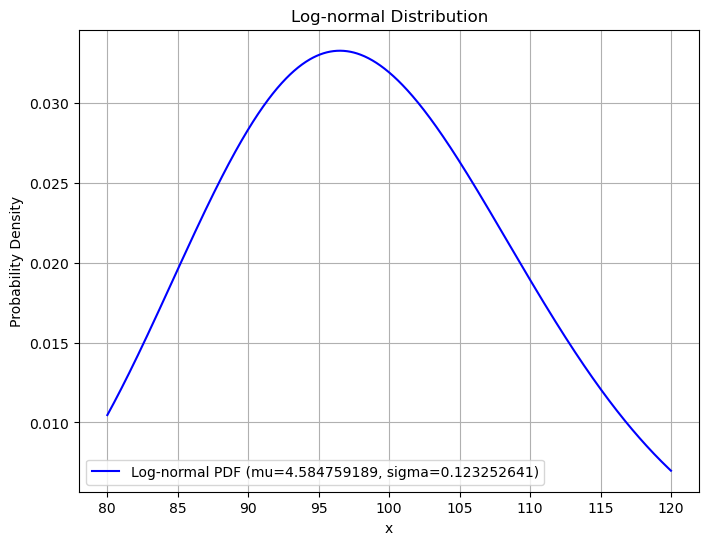

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Parameters for the log-normal distribution
mu = 4.584759189
  # Mean of the underlying normal distribution
sigma = 0.123252641  # Standard deviation of the underlying normal distribution

# Create a range of x values (log-normal is defined for x > 0)
x = np.linspace(lognorm.ppf(0.05, s=sigma, scale=np.exp(mu)), lognorm.ppf(0.95, s=sigma, scale=np.exp(mu)), 1000)

# Calculate the PDF of the log-normal distribution
pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))

display(lognorm.mean(s=sigma, scale=np.exp(mu)))
display(lognorm.var(s=sigma, scale=np.exp(mu)))

# Plot the PDF
plt.figure(figsize=(8, 6))
plt.plot(x, pdf, label=f'Log-normal PDF (mu={mu}, sigma={sigma})', color='blue')
plt.title('Log-normal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


# Context Preparation

our data is already tidy, but we need to further processing it to provide the context for the model. this part is somewhat related to the mathmatical formulation

## Basic constraints

### land area:

- for each year:
  - for each land:
    - sum of plant area of all configs <= land area

### plant legumes at least once within three years 这个其实可以是连续的，也可以是离散的。
- 连续的话规定三年种植面积之和大于土地面积应该就行了
  - 真的吗？


- for each land:
  - for every consecutive three years:
    - sum of plant area of all legumes >= land area


### avoid continuously planted in the same plot:应该是一个离散约束。简单规定，不能两年连续种同一种作物

问题：两季连续重茬种植算不算？

- for each land:
  - for every consecutive two years:
    - for every config:
        - x_{year, config} == 0 or x_{year+1, config} == 0


### avoiding scattered planting areas for each crop per season这个也可以是连续的，也可以是离散的。
- 连续的话用方差/基尼系数/熵/hhi（涉及到一些凸优化）
  - 但是好像不太对，这里其实需求不是有多“分散”，而是有多“稀疏”
    - 比如[2, 2, 2, 2, 2]和[9, 0.25, 0.25, 0.25, 0.25]，按照这些指标来看，当然前者分散后者集中，但按题意，其实这两个半斤八两（
- 离散的话直接规定每种作物 现在用了多少块地 <= 这个种植量下应该最少用几块地 + 允许多用的块数
  - 然后再用一个线性函数近似表达一下“这个种植量下应该最少用几块地”（？）


- for each crop:
  - number of crops planted in each plot <= 

### avoiding small portion of planting area in each plot for each crop




## Special constraints

- 水稻不能和其他作物合种
- 水浇地第二季只能种大白菜、白萝卜、红萝卜三种**之一**
- 榆黄菇，香菇，白灵菇，羊肚菌只能秋冬种（第二季是在 9 月至下一年 4 月前后）


In [16]:
assert len(land_data['地块名称'].unique()) == len(land_data)

# Define Model


In [17]:
import gurobipy as gp
from gurobipy import GRB

# constants
YEARS = 7
MAX_X = 100
MIN_X = 0.001

model = gp.Model("agri")

# (year, configs) "每年的配置"
x = model.addMVar((YEARS, len(configs_w_profit)), lb=0, vtype=GRB.CONTINUOUS, name="x")
y = model.addMVar((YEARS, len(configs_w_profit)), vtype=GRB.BINARY, name="y")

# bind x and y: y in {0, 1} iff x in R > 0
model.addConstr(x <= MAX_X * y, name="upper_bound")
model.addConstr(x >= MIN_X * y, name="lower_bound")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-12


<MConstr (7, 1062) *awaiting model update*>

In [18]:
# objective function

# automatically handled by broadcasting
# x.shape = (7, 1062)
# profits.shape = (1062,) -> (1, 1062)
# x@profits.shape = (7, 1062) @ (1, 1062) = (7,)
profits = configs_w_profit['profit'].values
model.setObjective((x@profits).sum(), GRB.MAXIMIZE)

In [19]:
### basic constraints

# land area
from gurobipy import and_
import numpy as np

for land_season in configs_w_profit['id_landseason'].unique():
    land_season_mask = configs_w_profit['id_landseason'] == land_season
    total_area = land_season_data.loc[land_season, '地块面积/亩']
    
    model.addConstr(x[:, land_season_mask].sum(axis=1) <= total_area, name=f"land_area_{land_season}")

# avoid continuously planted in the same plot
lands = configs_w_profit['地块名称'].unique()
for land in lands:
    land_mask = configs_w_profit['地块名称'] == land
    crops_share_land = np.where(land_mask)[0]
    
    # gurobi doesn't support vector equality, so we need to loop through each element
    # it also doesn't support 0 == and_(y[i, j], y[i+1, j]), so we need to 
    # use 0 == lhs, lhs == and_(y[i, j], y[i+1, j])
    for i in range(YEARS-1):
        lhs = model.addMVar((len(crops_share_land),), vtype=GRB.BINARY)
        rhs = list(and_(y[i, j], y[i+1, j]) for j in crops_share_land)
        model.addConstrs((lhs[k] == rhs[k] for k in range(len(crops_share_land))), name='continuously_planted_1')
        model.addConstr(0 == lhs, name="continuously_planted_2")

In [20]:
# plant legumes at least once within three years

legume_mask = configs_w_profit['id_crop'].isin(crop_data.loc[crop_data['legume'], 'id'])
for land in lands:
    land_mask = configs_w_profit['地块名称'] == land
    total_area = land_data.loc[land_data['地块名称'] == land, '地块面积/亩'].values[0]
    for i in range(YEARS-2): # 0, 1, 2, 3, 4
        model.addConstr(x[i:i+3, legume_mask & land_mask].sum() >= total_area, name=f"legume_{land}_{i}")

In [21]:
# special constraints
# 水稻不能和其他作物合种: y_水稻 -> 同一块地的第一季、第二季不种任何作物
land_mask = configs_w_profit['地块类型'] == '水浇地'
crop_mask = configs_w_profit['作物名称'] == '水稻'

# crops_share_land = and_(y[:, land_mask & ~crop_mask]).sum(axis=1)
crops_share_land = configs_w_profit[land_mask & ~crop_mask].reset_index()[['index', '地块名称']]
# .pivot(columns='index', index='地块名称')
# crops_share_land
aggregate_matrix = pd.crosstab(crops_share_land['index'], crops_share_land['地块名称']).values

planted_other_crop = x[:, land_mask & ~crop_mask] @ aggregate_matrix
model.addGenConstrIndicator(y[:, land_mask & crop_mask], 1, planted_other_crop, GRB.EQUAL, 0)

<MGenConstr (7, 8) *awaiting model update*>

In [22]:
# 水浇地第二季只能种大白菜、白萝卜、红萝卜三种**之一**
# TODO 应该跟水稻类似

In [23]:
model.write("model.lp")

In [24]:
model.optimize()
solution = x.X
print(f"Obj: {model.ObjVal:g}")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 4700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 22140 rows, 21240 columns and 46932 nonzeros
Model fingerprint: 0xcbfad9cc
Model has 6428 general constraints

CPU model: AMD Ryzen 7 4700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 22140 rows, 21240 columns and 46932 nonzeros
Model fingerprint: 0xcbfad9cc
Model has 6428 general constraints
Variable types: 7434 continuous, 13806 integer (13806 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+02]
  Objective range  [8e+02, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 9e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 21401 rows and 20736 columns
Presolve time: 0.60s
Presolved

# Write solution to file
convert into the format seen in the result file & save it

In [25]:
# 单季存在第一季里
configs_w_profit['季次'] = configs_w_profit['季次'].replace('单季', '第一季')
for i in range(YEARS):
    configs_w_profit[f'solution'] = solution[i]
    result = configs_w_profit.pivot(index=['季次', '地块名称'], columns='id_crop', values='solution').fillna('')
    excel_util.export_to_excel(result, workbook_path_result_1, f'{2024+i}', 
                           include_columns=False, include_index=False, start_position="C2")